##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Creating Keras Models with TFL Layers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/keras_layers"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/lattice/blob/master/docs/tutorials/keras_layers.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/lattice/blob/master/docs/tutorials/keras_layers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/lattice/docs/tutorials/keras_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

##Overview

You can use TFL Keras layers to construct Keras models with monotonicity and other shape constraints. This example builds and trains a calibrated lattice model for the UCI heart dataset using TFL layers.

In a calibrated lattice model, each feature is transformed by a `tfl.layers.PWLCalibration` or a `tfl.layers.CategoricalCalibration` layer and the results are nonlinearly fused using a `tfl.layers.Lattice`.

## Setup

Installing TF Lattice package:

In [2]:
#@test {"skip": true}
!pip install -U tensorflow tf-keras tensorflow-lattice  pydot graphviz

  Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl.metadata (1.8 kB)


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)


Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl (219 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


Importing required packages:

In [3]:
import tensorflow as tf

import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)

2024-12-15 12:19:48.259455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734265188.283238   43838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734265188.290507   43838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Downloading the UCI Statlog (Heart) dataset:

In [5]:
# UCI Statlog (Heart) dataset.
csv_file = keras.utils.get_file(
    'heart.csv', 'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
training_data_df = pd.read_csv(csv_file).sample(
    frac=1.0, random_state=41).reset_index(drop=True)
training_data_df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   61    1   4       120   260    0        0      140      1      3.6      2   
1   45    1   3       110   264    0        1      132      0      1.2      1   
2   47    1   3       130   253    0        0      179      0      0.0      1   
3   59    1   3       150   212    1        0      157      0      1.6      1   
4   55    0   4       128   205    0        1      130      1      2.0      2   

   ca        thal  target  
0   1  reversible       1  
1   0      normal       0  
2   0      normal       0  
3   0      normal       0  
4   1  reversible       1

Setting the default values used for training in this guide:

In [6]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 100

## Sequential Keras Model

This example creates a Sequential Keras model and only uses TFL layers.

Lattice layers expect `input[i]` to be within `[0, lattice_sizes[i] - 1.0]`, so we need to define the lattice sizes ahead of the calibration layers so we can properly specify output range of the calibration layers.


In [7]:
# Lattice layer expects input[i] to be within [0, lattice_sizes[i] - 1.0], so
lattice_sizes = [3, 2, 2, 2, 2, 2, 2]

We use a `tfl.layers.ParallelCombination` layer to group together calibration layers which have to be executed in parallel in order to be able to create a Sequential model.


In [8]:
combined_calibrators = tfl.layers.ParallelCombination()

We create a calibration layer for each feature and add it to the parallel combination layer. For numeric features we use `tfl.layers.PWLCalibration`, and for categorical features we use `tfl.layers.CategoricalCalibration`.

In [9]:
# ############### age ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(
        training_data_df['age'].min(), training_data_df['age'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
)
combined_calibrators.append(calibrator)

# ############### sex ###############
# For boolean features simply specify CategoricalCalibration layer with 2
# buckets.
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[1] - 1.0,
    # Initializes all outputs to (output_min + output_max) / 2.0.
    kernel_initializer='constant')
combined_calibrators.append(calibrator)

# ############### cp ###############
calibrator = tfl.layers.PWLCalibration(
    # Here instead of specifying dtype of layer we convert keypoints into
    # np.float32.
    input_keypoints=np.linspace(1, 4, num=4, dtype=np.float32),
    output_min=0.0,
    output_max=lattice_sizes[2] - 1.0,
    monotonicity='increasing',
    # You can specify TFL regularizers as a tuple ('regularizer name', l1, l2).
    kernel_regularizer=('hessian', 0.0, 1e-4))
combined_calibrators.append(calibrator)

# ############### trestbps ###############
calibrator = tfl.layers.PWLCalibration(
    # Alternatively, you might want to use quantiles as keypoints instead of
    # uniform keypoints
    input_keypoints=np.quantile(training_data_df['trestbps'],
                                np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    # Together with quantile keypoints you might want to initialize piecewise
    # linear function to have 'equal_slopes' in order for output of layer
    # after initialization to preserve original distribution.
    kernel_initializer='equal_slopes',
    output_min=0.0,
    output_max=lattice_sizes[3] - 1.0,
    # You might consider clamping extreme inputs of the calibrator to output
    # bounds.
    clamp_min=True,
    clamp_max=True,
    monotonicity='increasing')
combined_calibrators.append(calibrator)

# ############### chol ###############
calibrator = tfl.layers.PWLCalibration(
    # Explicit input keypoint initialization.
    input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
    dtype=tf.float32,
    output_min=0.0,
    output_max=lattice_sizes[4] - 1.0,
    # Monotonicity of calibrator can be decreasing. Note that corresponding
    # lattice dimension must have INCREASING monotonicity regardless of
    # monotonicity direction of calibrator.
    monotonicity='decreasing',
    # Convexity together with decreasing monotonicity result in diminishing
    # return constraint.
    convexity='convex',
    # You can specify list of regularizers. You are not limited to TFL
    # regularizrs. Feel free to use any :)
    kernel_regularizer=[('laplacian', 0.0, 1e-4),
                        keras.regularizers.l1_l2(l1=0.001)])
combined_calibrators.append(calibrator)

# ############### fbs ###############
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[5] - 1.0,
    # For categorical calibration layer monotonicity is specified for pairs
    # of indices of categories. Output for first category in pair will be
    # smaller than output for second category.
    #
    # Don't forget to set monotonicity of corresponding dimension of Lattice
    # layer to '1'.
    monotonicities=[(0, 1)],
    # This initializer is identical to default one('uniform'), but has fixed
    # seed in order to simplify experimentation.
    kernel_initializer=keras.initializers.RandomUniform(
        minval=0.0, maxval=lattice_sizes[5] - 1.0, seed=1))
combined_calibrators.append(calibrator)

# ############### restecg ###############
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=3,
    output_min=0.0,
    output_max=lattice_sizes[6] - 1.0,
    # Categorical monotonicity can be partial order.
    monotonicities=[(0, 1), (0, 2)],
    # Categorical calibration layer supports standard Keras regularizers.
    kernel_regularizer=keras.regularizers.l1_l2(l1=0.001),
    kernel_initializer='constant')
combined_calibrators.append(calibrator)

We then create a lattice layer to nonlinearly fuse the outputs of the calibrators.

Note that we need to specify the monotonicity of the lattice to be increasing for required dimensions. The composition with the direction of the monotonicity in the calibration will result in the correct end-to-end direction of monotonicity. This includes partial monotonicity of CategoricalCalibration layer.

In [10]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing', 'none', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing'
    ],
    output_min=0.0,
    output_max=1.0)

We can then create a sequential model using the combined calibrators and lattice layers.

In [11]:
model = keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)

2024-12-15 12:19:51.161765: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training works the same as any other keras model.

In [12]:
features = training_data_df[[
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg'
]].values.astype(np.float32)
target = training_data_df[['target']].values.astype(np.float32)

model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adagrad(learning_rate=LEARNING_RATE))
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    shuffle=False,
    verbose=0)

model.evaluate(features, target)

 1/10 [==>...........................] - ETA: 0s - loss: 0.1265

10/10 [==============================] - 0s 2ms/step - loss: 0.1551


0.15509344637393951

## Functional Keras Model

This example uses a functional API for Keras model construction.

As mentioned in the previous section, lattice layers expect `input[i]` to be within `[0, lattice_sizes[i] - 1.0]`, so we need to define the lattice sizes ahead of the calibration layers so we can properly specify output range of the calibration layers.

In [13]:
# We are going to have 2-d embedding as one of lattice inputs.
lattice_sizes = [3, 2, 2, 3, 3, 2, 2]

For each feature, we need to create an input layer followed by a calibration layer. For numeric features we use `tfl.layers.PWLCalibration` and for categorical features we use `tfl.layers.CategoricalCalibration`.

In [14]:
model_inputs = []
lattice_inputs = []
# ############### age ###############
age_input = keras.layers.Input(shape=[1], name='age')
model_inputs.append(age_input)
age_calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(
        training_data_df['age'].min(), training_data_df['age'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
    monotonicity='increasing',
    name='age_calib',
)(
    age_input)
lattice_inputs.append(age_calibrator)

# ############### sex ###############
# For boolean features simply specify CategoricalCalibration layer with 2
# buckets.
sex_input = keras.layers.Input(shape=[1], name='sex')
model_inputs.append(sex_input)
sex_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[1] - 1.0,
    # Initializes all outputs to (output_min + output_max) / 2.0.
    kernel_initializer='constant',
    name='sex_calib',
)(
    sex_input)
lattice_inputs.append(sex_calibrator)

# ############### cp ###############
cp_input = keras.layers.Input(shape=[1], name='cp')
model_inputs.append(cp_input)
cp_calibrator = tfl.layers.PWLCalibration(
    # Here instead of specifying dtype of layer we convert keypoints into
    # np.float32.
    input_keypoints=np.linspace(1, 4, num=4, dtype=np.float32),
    output_min=0.0,
    output_max=lattice_sizes[2] - 1.0,
    monotonicity='increasing',
    # You can specify TFL regularizers as tuple ('regularizer name', l1, l2).
    kernel_regularizer=('hessian', 0.0, 1e-4),
    name='cp_calib',
)(
    cp_input)
lattice_inputs.append(cp_calibrator)

# ############### trestbps ###############
trestbps_input = keras.layers.Input(shape=[1], name='trestbps')
model_inputs.append(trestbps_input)
trestbps_calibrator = tfl.layers.PWLCalibration(
    # Alternatively, you might want to use quantiles as keypoints instead of
    # uniform keypoints
    input_keypoints=np.quantile(training_data_df['trestbps'],
                                np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    # Together with quantile keypoints you might want to initialize piecewise
    # linear function to have 'equal_slopes' in order for output of layer
    # after initialization to preserve original distribution.
    kernel_initializer='equal_slopes',
    output_min=0.0,
    output_max=lattice_sizes[3] - 1.0,
    # You might consider clamping extreme inputs of the calibrator to output
    # bounds.
    clamp_min=True,
    clamp_max=True,
    monotonicity='increasing',
    name='trestbps_calib',
)(
    trestbps_input)
lattice_inputs.append(trestbps_calibrator)

# ############### chol ###############
chol_input = keras.layers.Input(shape=[1], name='chol')
model_inputs.append(chol_input)
chol_calibrator = tfl.layers.PWLCalibration(
    # Explicit input keypoint initialization.
    input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
    output_min=0.0,
    output_max=lattice_sizes[4] - 1.0,
    # Monotonicity of calibrator can be decreasing. Note that corresponding
    # lattice dimension must have INCREASING monotonicity regardless of
    # monotonicity direction of calibrator.
    monotonicity='decreasing',
    # Convexity together with decreasing monotonicity result in diminishing
    # return constraint.
    convexity='convex',
    # You can specify list of regularizers. You are not limited to TFL
    # regularizrs. Feel free to use any :)
    kernel_regularizer=[('laplacian', 0.0, 1e-4),
                        keras.regularizers.l1_l2(l1=0.001)],
    name='chol_calib',
)(
    chol_input)
lattice_inputs.append(chol_calibrator)

# ############### fbs ###############
fbs_input = keras.layers.Input(shape=[1], name='fbs')
model_inputs.append(fbs_input)
fbs_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[5] - 1.0,
    # For categorical calibration layer monotonicity is specified for pairs
    # of indices of categories. Output for first category in pair will be
    # smaller than output for second category.
    #
    # Don't forget to set monotonicity of corresponding dimension of Lattice
    # layer to '1'.
    monotonicities=[(0, 1)],
    # This initializer is identical to default one ('uniform'), but has fixed
    # seed in order to simplify experimentation.
    kernel_initializer=keras.initializers.RandomUniform(
        minval=0.0, maxval=lattice_sizes[5] - 1.0, seed=1),
    name='fbs_calib',
)(
    fbs_input)
lattice_inputs.append(fbs_calibrator)

# ############### restecg ###############
restecg_input = keras.layers.Input(shape=[1], name='restecg')
model_inputs.append(restecg_input)
restecg_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=3,
    output_min=0.0,
    output_max=lattice_sizes[6] - 1.0,
    # Categorical monotonicity can be partial order.
    monotonicities=[(0, 1), (0, 2)],
    # Categorical calibration layer supports standard Keras regularizers.
    kernel_regularizer=keras.regularizers.l1_l2(l1=0.001),
    kernel_initializer='constant',
    name='restecg_calib',
)(
    restecg_input)
lattice_inputs.append(restecg_calibrator)

We then create a lattice layer to nonlinearly fuse the outputs of the calibrators.

Note that we need to specify the monotonicity of the lattice to be increasing for required dimensions. The composition with the direction of the monotonicity in the calibration will result in the correct end-to-end direction of monotonicity. This includes partial monotonicity of `tfl.layers.CategoricalCalibration` layer.

In [15]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing', 'none', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing'
    ],
    output_min=0.0,
    output_max=1.0,
    name='lattice',
)(
    lattice_inputs)

To add more flexibility to the model, we add an output calibration layer.

In [16]:
model_output = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0.0, 1.0, 5),
    name='output_calib',
)(
    lattice)

We can now create a model using the inputs and outputs.

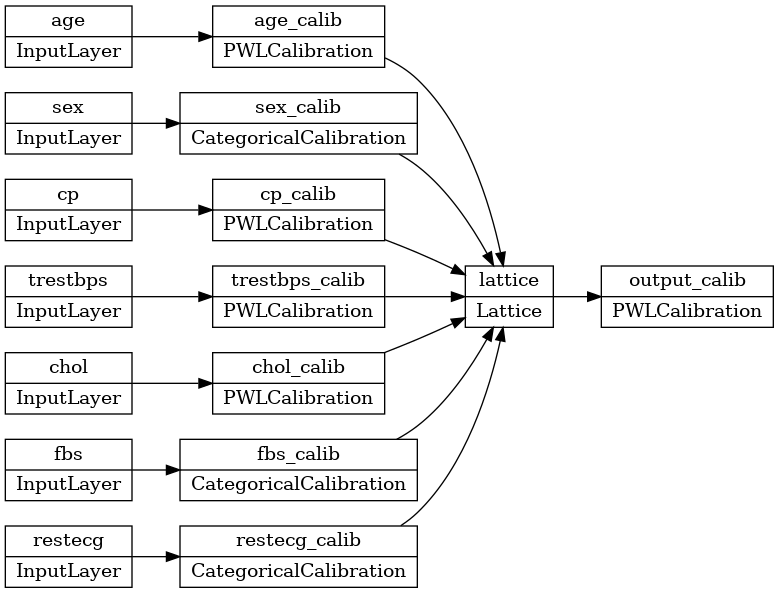

In [17]:
model = keras.models.Model(
    inputs=model_inputs,
    outputs=model_output)
keras.utils.plot_model(model, rankdir='LR')

Training works the same as any other keras model. Note that, with our setup, input features are passed as separate tensors.

In [18]:
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg']
features = np.split(
    training_data_df[feature_names].values.astype(np.float32),
    indices_or_sections=len(feature_names),
    axis=1)
target = training_data_df[['target']].values.astype(np.float32)

model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adagrad(LEARNING_RATE))
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    shuffle=False,
    verbose=0)

model.evaluate(features, target)

 1/10 [==>...........................] - ETA: 0s - loss: 0.1372

10/10 [==============================] - 0s 2ms/step - loss: 0.1580


0.15800504386425018